In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.regression import *
from torchmetrics.classification import *
from torchmetrics.functional.regression import r2_score
from torchmetrics.functional.classification import f1_score

import sys
sys.path.append('/Users/anhyojun/VSCode/K-Digital Training/MyModule')
from CustomModel import DeepModel
from DataSet import CustomDataset
from TorchTrainTest import training, testing
from LossScorePlot import DrawPlot

In [ ]:
torch.manual_seed(1) # 시드 설정

In [ ]:
def make_dict(DataFile):
    en1_dict = {}

    en1 = []

    with open(DataFile, 'r', encoding='utf-8') as f:
        for i in f:
            if (i != '\n') and len(i.strip()) >= 2:
                en1.append(i.strip())

    en1_dict = {chr(i) : 0 for i in range(97, 123)}

    for i in en1:
        for j in i:
            if (65 <= ord(j) <= 90) or (97 <= ord(j) <= 122):
                en1_dict[j.lower()] += 1

    return {key : value for key, value in zip(en1_dict.keys(), [i/sum(en1_dict.values()) for i in en1_dict.values()])}

In [ ]:
def make_df(language, dataset, start_num, end_num):
    lan_list = []
    for i in range(start_num,end_num+1):
        file_dir = f'[머신러닝] 과제 데이터셋/{dataset}/{language}-{i}.txt'
        lan_list.append(make_dict(file_dir))

    en_df = pd.DataFrame(lan_list)
    en_df['language'] = [language] * (end_num-start_num+1)
    return en_df

In [ ]:
train_en = make_df('en', 'train', 1, 20)
train_fr = make_df('fr', 'train', 1, 20)
train_id = make_df('id', 'train', 1, 20)
train_tl = make_df('tl', 'train', 1, 20)

train_df = pd.concat([train_en, train_fr, train_id, train_tl]).reset_index(drop = True)
train_df['language'] = train_df['language'].replace({'en' : 0, 'fr' : 1, 'id' : 2, 'tl' : 3})
train_df

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,language
0,0.076101,0.012865,0.045792,0.046228,0.104884,0.015700,0.019189,0.043829,0.074139,0.001744,...,0.077846,0.061491,0.080026,0.025949,0.009158,0.014174,0.000654,0.020061,0.000436,0
1,0.084238,0.019926,0.030426,0.038898,0.136857,0.017420,0.031261,0.027443,0.075409,0.002625,...,0.090204,0.071710,0.077556,0.030665,0.013483,0.013960,0.002028,0.010739,0.000597,0
2,0.071825,0.012202,0.045757,0.032723,0.119523,0.014698,0.025236,0.023572,0.094842,0.002496,...,0.054077,0.088186,0.080422,0.029118,0.018026,0.011925,0.000555,0.018026,0.000555,0
3,0.072251,0.027731,0.029994,0.039615,0.120921,0.016789,0.023580,0.059045,0.065271,0.001509,...,0.059234,0.073382,0.093567,0.024335,0.004905,0.019619,0.006037,0.017544,0.001698,0
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.223182,0.024521,0.008125,0.013139,0.024229,0.003514,0.096366,0.018775,0.087216,0.001244,...,0.017677,0.049043,0.054496,0.027486,0.002452,0.012371,0.000512,0.020130,0.001061,3
76,0.219981,0.017919,0.004989,0.013994,0.023060,0.001795,0.089897,0.016884,0.085151,0.000700,...,0.023182,0.054121,0.044872,0.032673,0.000639,0.009096,0.000304,0.028171,0.000152,3
77,0.229756,0.021014,0.002522,0.012777,0.029812,0.000280,0.091454,0.011264,0.070384,0.001793,...,0.026898,0.047352,0.059569,0.034744,0.001065,0.014290,0.000056,0.019725,0.000056,3
78,0.177605,0.022741,0.019023,0.021790,0.064937,0.004929,0.066926,0.019023,0.074535,0.001902,...,0.045914,0.058971,0.054734,0.027756,0.005102,0.008214,0.000865,0.023346,0.002681,3


In [ ]:
test_en = make_df('en', 'test', 1, 2)
test_fr = make_df('fr', 'test', 3, 4)
test_id = make_df('id', 'test', 5, 6)
test_tl = make_df('tl', 'test', 7, 8)

test_df = pd.concat([test_en, test_fr, test_id, test_tl]).reset_index(drop = True)
test_df['language'] = test_df['language'].replace({'en' : 0, 'fr' : 1, 'id' : 2, 'tl' : 3})
test_df

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,language
0,0.067845,0.013464,0.034339,0.048833,0.116042,0.020020,0.016007,0.022805,0.076945,0.002412,...,0.070147,0.079576,0.075037,0.025919,0.014670,0.036115,0.005635,0.013091,0.000417,0
1,0.080292,0.016176,0.035354,0.038346,0.129841,0.016706,0.018952,0.042702,0.073995,0.004463,...,0.066235,0.063606,0.078850,0.027634,0.012988,0.014881,0.002119,0.013302,0.001491,0
2,0.056764,0.012008,0.035835,0.049876,0.127155,0.013476,0.008620,0.007303,0.086050,0.002786,...,0.067304,0.090078,0.068433,0.042912,0.013852,0.028909,0.009298,0.005157,0.000414,1
3,0.071875,0.011413,0.038476,0.040330,0.139357,0.012185,0.015386,0.018410,0.079491,0.004150,...,0.064060,0.073023,0.066334,0.048652,0.013598,0.002892,0.004282,0.003355,0.001192,1
4,0.104424,0.022121,0.015290,0.044242,0.089460,0.011386,0.026675,0.015615,0.090599,0.005368,...,0.069616,0.079050,0.052863,0.036923,0.016591,0.033669,0.004880,0.009597,0.000488,2
5,0.164742,0.026059,0.014590,0.041585,0.088281,0.005969,0.036007,0.025123,0.082078,0.007256,...,0.053640,0.048802,0.053250,0.047437,0.004681,0.004603,0.000468,0.014824,0.000585,2
6,0.185617,0.019561,0.014375,0.026729,0.033097,0.007969,0.082552,0.014070,0.081751,0.000229,...,0.035842,0.058720,0.052162,0.023793,0.004804,0.028369,0.003394,0.017082,0.000419,3
7,0.167981,0.016374,0.018799,0.024864,0.055791,0.009096,0.066707,0.011522,0.070346,0.000606,...,0.044269,0.052759,0.061249,0.036992,0.001819,0.016374,0.000606,0.018193,0.000606,3


In [ ]:
train_inputDF = train_df.iloc[:,:-1]
train_targetDF = train_df.iloc[:,[-1]]
test_inputDF = test_df.iloc[:,:-1]
test_targetDF = test_df.iloc[:,[-1]]

In [ ]:
# train, valid, test 분리
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                                train_size = 0.8,
                                                                                stratify = train_targetDF,
                                                                                random_state = 42)

In [ ]:
print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (64, 26), target : (64, 1)
[valid] input : (16, 26), target : (16, 1)
[test] input : (8, 26), target : (8, 1)


In [ ]:
# 데이터셋 생성
trainDS = CustomDataset(train_inputDF, train_targetDF)
validDS = CustomDataset(valid_inputDF, valid_targetDF)

# 데이터셋 속성
print(f"trainDS shape : ({trainDS.n_rows}, {trainDS.n_features})")
print(f"testDS : ({validDS.n_rows}, {validDS.n_features})")

# 데이터로더 인스턴스 생성
trainDL = DataLoader(trainDS, batch_size=4)
validDL = DataLoader(validDS, batch_size=4)

trainDS shape : (64, 26)
testDS : (16, 26)


In [ ]:
# 모델 인스턴스 생성
model = DeepModel(input_in=len(train_inputDF.columns), output_out=len(train_targetDF.value_counts()),
                  hidden_list=[50, 30], act_func=F.relu, is_reg=False, is_bin=False)
print(model)
summary(model)

DeepModel(
  (input_layer): Linear(in_features=26, out_features=50, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
  )
  (output_layer): Linear(in_features=30, out_features=4, bias=True)
)


Layer (type:depth-idx)                   Param #
DeepModel                                --
├─Linear: 1-1                            1,350
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       1,530
├─Linear: 1-3                            124
Total params: 3,004
Trainable params: 3,004
Non-trainable params: 0

In [ ]:
for feature, target in trainDL:
    print(feature, target, sep='\n')
    break

tensor([[0.0842, 0.0199, 0.0304, 0.0389, 0.1369, 0.0174, 0.0313, 0.0274, 0.0754,
         0.0026, 0.0098, 0.0424, 0.0242, 0.0536, 0.0688, 0.0203, 0.0055, 0.0902,
         0.0717, 0.0776, 0.0307, 0.0135, 0.0140, 0.0020, 0.0107, 0.0006],
        [0.0988, 0.0090, 0.0392, 0.0366, 0.1415, 0.0091, 0.0142, 0.0091, 0.1040,
         0.0019, 0.0021, 0.0579, 0.0261, 0.0745, 0.0566, 0.0330, 0.0093, 0.0668,
         0.0693, 0.0737, 0.0381, 0.0101, 0.0022, 0.0106, 0.0024, 0.0037],
        [0.0779, 0.0149, 0.0357, 0.0448, 0.1497, 0.0118, 0.0115, 0.0126, 0.0720,
         0.0021, 0.0019, 0.0650, 0.0315, 0.0688, 0.0569, 0.0292, 0.0068, 0.0747,
         0.0821, 0.0706, 0.0545, 0.0106, 0.0045, 0.0039, 0.0053, 0.0005],
        [0.1018, 0.0076, 0.0547, 0.0519, 0.1431, 0.0118, 0.0159, 0.0123, 0.0700,
         0.0043, 0.0003, 0.0557, 0.0358, 0.0862, 0.0466, 0.0176, 0.0048, 0.0635,
         0.0748, 0.0713, 0.0459, 0.0164, 0.0028, 0.0028, 0.0023, 0.0000]])
tensor([[0.],
        [1.],
        [1.],
        [1.]]

In [ ]:
# 옵티마이저 (모델의 가중치 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.001)
# 가중치, 절편을 전달하고 학습률을 설정

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/VSCode/K-Digital Training/김소현 강사님/Pytorch/숙제/language_model'
result = training(trainDL, validDL, model, 'multiclass', adam_optim, EPOCH,
                  endurance_cnt=5, num_classes=10, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 1.3857, Test : 1.3841
[Score  : 1/200] Train : 0.2500, Test : 0.2500
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/200] Train : 1.3836, Test : 1.3826
[Score  : 2/200] Train : 0.2500, Test : 0.2500
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/200] Train : 1.3819, Test : 1.3808
[Score  : 3/200] Train : 0.2500, Test : 0.2500
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/200] Train : 1.3798, Test : 1.3786
[Score  : 4/200] Train : 0.2656, Test : 0.3125
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/200] Train : 1.3772, Test : 1.3758
[Score  : 5/200] Train : 0.4688, Test : 0.5000
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/200] Train : 1.3737, Test : 1.3719
[Score  : 6/200] Train : 0.5000, Test : 0.5000
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/200] Train : 1.3688, Test : 1.3665
[Score  : 7/200] Train : 0.5000, Test : 0.5000
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/200] Train : 1.3620, Test : 1.3590
[Score  : 8/200] Train : 0.5000, Test : 0.5000
[EPOCH] : 9에서 모델 저장 완료.
[Loss : 9/200] Train : 1.3523, Test : 1.3483
[Sc

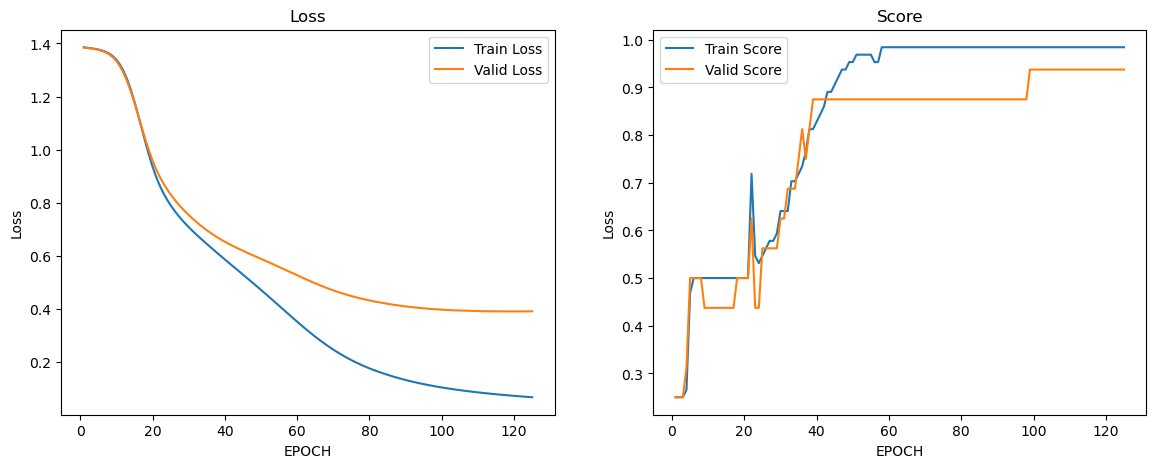

In [ ]:
DrawPlot(result)

### 학습을 마친 모델로 예측 수행

In [ ]:
loaded_model =